# A/B Testing

A/B Testing Project
Task
You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.<p>
Technical description<p>
-	Test name: recommender_system_test
-	Groups: А (control), B (new payment funnel)
-	Launch date: 2020-12-07
-	Date when they stopped taking up new users: 2020-12-21
-	End date: 2021-01-01
-	Audience: 15% of the new users from the EU region
-	Purpose of the test: testing changes related to the introduction of an improved recommendation system
-	Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.
-	Expected number of test participants: 6000,<p>
Download the test data, see whether it was carried out correctly, and analyze the results.


-	`ab_project_marketing_events_us.csv` — the calendar of marketing events for 2020
-	`final_ab_new_users_us.csv` — all users who signed up in the online store from December 7 to 21, 2020
-	`final_ab_events_us.csv` — all events of the new users within the period from December 7, 2020 through January 1, 2021
-	`final_ab_participants_us.csv` — table containing test participants



__Table of Content__<p> <a class="anchor" id="content1"></a>

* [Step 1. Describe the goals of the study](#step1)
* [Step 2. Data Explore](#step2)
* [Step 3. Exploratory Data Analysis (EDA)](#step3)
* [Step 4. Evaluate the A/B test results](#step4)
* [Step 5. Conclusions of EDA stage and the A/B test results](#step5)


# Step 1 - Describe the goals of the study <a class="anchor" id="step1"></a>
---

- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.

In [1]:
# import:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats
import datetime
from datetime import datetime
from scipy import stats as st
import math
import math as mth
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
# df from csv files:
# local

marketing_events = pd.read_csv('/content/ab_project_marketing_events_us.csv',
                               parse_dates=['start_dt','finish_dt'])

events = pd.read_csv('/content/final_ab_events_us.csv',
                     parse_dates=['event_dt'],
                     dtype={'event_name':'category'})
users = pd.read_csv('/content/final_ab_new_users_us.csv',
                    parse_dates=['first_date'],
                    dtype={'region':'category','device':'category'})

participants = pd.read_csv('/content/final_ab_participants_us.csv',
                           dtype={'group':'category','ab_test':'category'})

[Back to ToC](#content1)

# Step 2 - Data Explore <p> <a class="anchor" id="step2"></a>
---  

-	Do types need to be converted?
-	Are there any missing or duplicate values? If so, how would you characterize them?


## _marketing_events_us_

In [3]:
marketing_events.info()
# datetime types - adjusted within the read_csv 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [4]:
# quick glance into data
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [5]:
# remove dupps
marketing_events.drop_duplicates(inplace=True)

In [6]:
# query to check the no finish date < start date
marketing_events.query('start_dt > finish_dt')
# no outpout - good result

,name,regions,start_dt,finish_dt


In [7]:
marketing_events.info()
# no change at total amount

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 560.0+ bytes


summary: 
- we made adjusmtment to the dates columns and converted them to datetime types
- no dupps or NaN values inside the df in the first place

## _events_us_

In [8]:
events.info()
# ok now - dtype adjustments made in the read_csv section

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  category      
 3   details     62740 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 10.5+ MB


In [9]:
events.head(1)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99


In [10]:
events.tail(1)

,user_id,event_dt,event_name,details
440316,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


within details columns we receive the purchase price only if the event_name is purchase so for the other events it makes sence that the value is missing

we will start by checking if the NaN values are correct for the correspoding event name<p>
if correct - we can replace NaN with zero (0) or stay with NaN as indicator to no purchase made

In [11]:
events['user_id'].value_counts()
# user_id shown multiple time since there are different time fames and event that a single user can be

A3917F81482141F2    36
590DACD07A839BC3    32
D6477068EF132236    32
426330B820B8711A    32
BA87FD8D70D63CC6    32
                    ..
947ADA57D42BFBD0     1
0CC00C37DE364A84     1
ACA4A1557127F2B8     1
912BBD0EA35F51A9     1
70EEA8BDDC26C220     1
Name: user_id, Length: 58703, dtype: int64

In [12]:
# a glance into types of events
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

In [13]:
# total number of values in the purchase event match total non-null rows we got in the .info() section
events['event_name'].value_counts()[[2]]

purchase    62740
Name: event_name, dtype: int64

In [14]:
# NaN in within details columns that are not purchase event
events.query('event_name != "purchase"')['details'].isnull().sum()

377577

In [15]:
# NaN in within details columns that are purchase event
events.query('event_name == "purchase"')['details'].isnull().sum()

0

In [16]:
# remove dupps if any:
events.drop_duplicates(inplace=True)

summary:
- managed to confirm that all the NaN values are related to non-purchase event so with that being said the NaN values are in good order and we stay with them as an indicator to "no-purchase" while a float number is a "purchase" sign
- all dtypes defined correctly

## _new_users_us_

In [17]:
users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [18]:
users.info()
# no NaN values + dtypes adjusted in the read_csv section

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  category      
 3   device      61733 non-null  category      
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.1+ MB


In [19]:
# quick check if region has dups that comes from lower/upper writing
users['region'].value_counts()
# ok here

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [20]:
# quick check if device has dups that comes from lower/upper writing
users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [21]:
users['user_id'].value_counts()
# everyr user appear only 1 time - a good confirmation for not having error in the data that may come from BI team
# by this we can also say that no dupps are in the data

C0B2B6226B5701E1    1
6E76C34C694FA0BE    1
55099832703E2009    1
C771D3F6428B854B    1
0D24D56EF42D5F36    1
                   ..
825F0FC19A07E5FF    1
DCCD1762C1C4D097    1
724D8F18B7345DE6    1
C63DEA62897E69E5    1
590EAAF83BC777D7    1
Name: user_id, Length: 61733, dtype: int64

summary:
- adjustments made in dtype definitions
- no NaN values detected
- drop dupps applied 

## _participants_us_

In [22]:
# quick look
participants.tail(5)

,user_id,group,ab_test
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test
18267,79F9ABFB029CF724,B,interface_eu_test


In [23]:
participants.info()
# no NaN value + dtype adjuested 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   user_id  18268 non-null  object  
 1   group    18268 non-null  category
 2   ab_test  18268 non-null  category
dtypes: category(2), object(1)
memory usage: 178.6+ KB


In [24]:
for col in participants.columns:
  print(participants[col].value_counts(),'\n')

# the same user_id appears more than once
# we need to disapprove that the same user is on the same test with different groups

7DF21AEB1AA231F9    2
6A59682D3C59519A    2
82F72EC6CDC1BA8F    2
2812C91B1E29180A    2
6B26B1B4BF1C3C2C    2
                   ..
172E77DF594D281C    1
AEF3BB32F4D0775E    1
8AFB3E6EA8574516    1
3D6EB94C6C2A7804    1
0A5150E6F59CCD35    1
Name: user_id, Length: 16666, dtype: int64 

A    9655
B    8613
Name: group, dtype: int64 

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64 



In [25]:
# interface_eu_test
participants.query('ab_test == "interface_eu_test"')['user_id'].value_counts()
# dissaproved within this test

55AEBB4BAAC70BD4    1
3945F4BE0D410B2F    1
9B255865EFB0D54E    1
7411A85E26DC5D1F    1
C0ED8DB8F8906BC9    1
                   ..
F2BE35774F63059B    1
AF9E37A23D7301B3    1
E347837A1EBB2E91    1
E4013600BF689DB7    1
C40DDE88F1919245    1
Name: user_id, Length: 11567, dtype: int64

In [26]:
# recommender_system_test
participants.query('ab_test == "recommender_system_test"')['user_id'].value_counts()
# dissaproved within this test as well

FBD8DEBEFD517D1F    1
FC47C747FEE7DB98    1
E4111A6C304075D8    1
90AC003E691D70D4    1
1544489D5476AD59    1
                   ..
A354B804BD270C75    1
49117FDB7FCCFA5A    1
BA5675493270C848    1
934F4410153B7733    1
1FD8662A41621AAF    1
Name: user_id, Length: 6701, dtype: int64

summary:
- we approved that each test contains unique user_id so we have no typo issue from this area where each A/B group consists of different users
- dtype adjusted


In row codes above [24-26] I'm trying to show that for each ab test (interface_eu_test & recommender_system_test) we have gor each user_id only once ergo we can say about it that every the same user can not be in both A and B group at the same ab test<p>
Now if we disregard the ab test column and looking in group at general we might found same user more than once and I was dealing with this issue in the z_score and ab test blocks<p>
Basically, we can add another query with AND function for each grop or a query to only group to found if there are unique users which is done later (ab test / aa test) in the tests part<p>


[Back to ToC](#content1)

# Step 3 - Exploratory Data Analysis (EDA) <a class="anchor" id="step3"></a>
---

- ## Study conversion at different stages of the funnel.


In [27]:
# find the number of unique users for each stage
conver_user = events.groupby('event_name').agg({'user_id': 'nunique'})
conver_user = conver_user.sort_values(by = 'user_id', ascending=False).reset_index()
conver_user

,event_name,user_id
0,login,58697
1,product_page,38929
2,purchase,19569
3,product_cart,19284


_purchase_cart will NOT be a part of the funnel<p>
Explanation: This can be because users may have a 'quick purchase' option and the can make purchase without reach product_cart stage_ <p>

In [28]:
# converstion to last stage
conver_user['conversion_last_stage'] = (conver_user['user_id'] / conver_user['user_id'].shift(1)).fillna(1).apply('{:.2%}'.format)
conver_user

,event_name,user_id,conversion_last_stage
0,login,58697,100.00%
1,product_page,38929,66.32%
2,purchase,19569,50.27%
3,product_cart,19284,98.54%


In [29]:
# total conversinon:
conver_user['total_conversion'] = (conver_user['user_id'] / conver_user.iloc[0,1]).apply('{:.2%}'.format)
conver_user

,event_name,user_id,conversion_last_stage,total_conversion
0,login,58697,100.00%,100.00%
1,product_page,38929,66.32%,66.32%
2,purchase,19569,50.27%,33.34%
3,product_cart,19284,98.54%,32.85%


In [30]:
# funnel graph with plotly
y = conver_user['event_name']
x = conver_user['user_id']
fig = go.Figure(go.Funnel(
    y = y,
    x = x,
    textinfo = "value+percent initial",))
fig.update_layout(title_x=0.5,
    height=800,
    title_text='Conversion at different stages of the funnel')

fig.show()

summary:
- from the moment user login a third  user will make a purchase
- 33% of users won't reach product page which is high figures and have space to improvements that can lead to higher conversion rates possible

- ## Is the number of events per user distributed equally among the samples?


In [31]:
# we refer to participants of "interface_eu_test" and how they are split in groups
dist_eu = participants.query('ab_test == "interface_eu_test"')['group'].value_counts()
dist_eu 

A    5831
B    5736
Name: group, dtype: int64

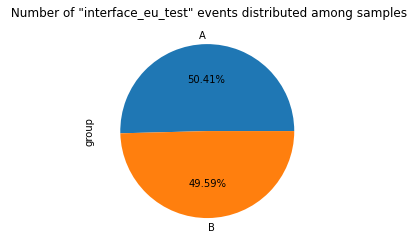

In [32]:
dist_eu.plot.pie(autopct="%.2f%%",title=' Number of "interface_eu_test" events distributed among samples');
#  equal groups - checked

summary:<p>
- A/B groups distributed  equally with uni

- ## Are there users who are present in both samples?


In [33]:
participants.query('ab_test == "interface_eu_test"')['user_id'].value_counts().sort_values(ascending=False)

C40DDE88F1919245    1
884DB9E76DDF3D86    1
BA3CFFC9A1EEDAF2    1
6C5EDC95CDCE6635    1
638877CEA94E8DC0    1
                   ..
C5274B8DF35C9218    1
DCB427AEBB338793    1
CF69DD8CA5F0E5C9    1
B2E2B7C6032F8B9D    1
55AEBB4BAAC70BD4    1
Name: user_id, Length: 11567, dtype: int64

_as was shown in the exploring section we do not have users present in both sample since we have each user only once in the whole "interface_eu_test"_

- ## How is the number of events distributed among days?


In [34]:
# first I will copy the original df 
events_ = events

In [35]:
# create date columns
events_['date'] = events_['event_dt'].dt.date.astype('datetime64[ns]')
events_.head(4)

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07


In [36]:
dist_days = pd.pivot_table(events_,index='date',columns='event_name',values='user_id',aggfunc=lambda x: x.nunique())
dist_days.head(4)

event_name,product_cart,product_page,purchase,login
date,,,,
2020-12-07,1582,3240,1650,4913
2020-12-08,1744,3627,1729,5447
2020-12-09,1704,3498,1693,5227
2020-12-10,1998,4022,2012,6045


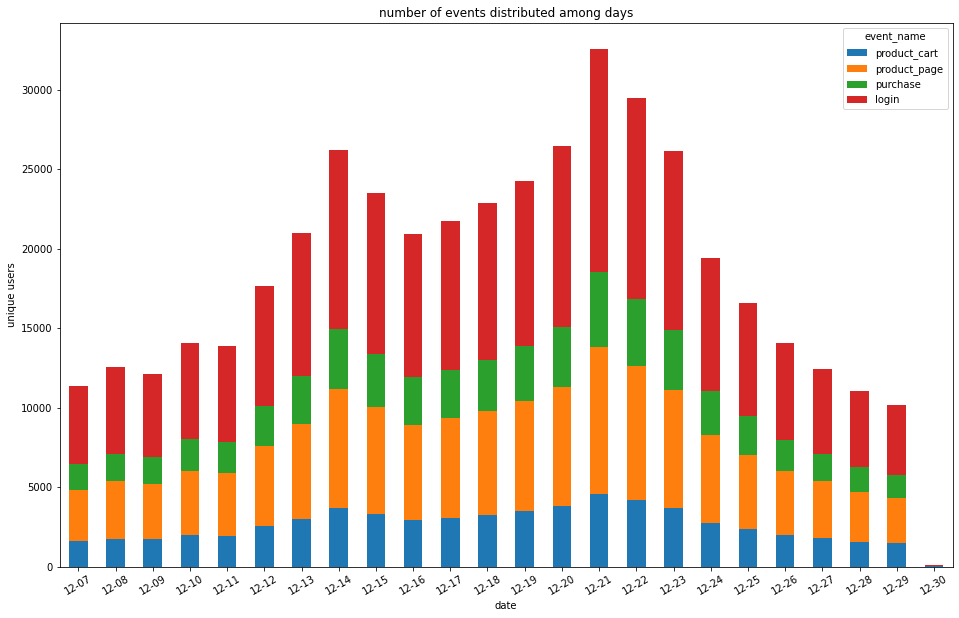

In [37]:
# now visualize via chart
# date show visualization improvement
ticklabels = ['']*len(dist_days.index)
ticklabels = [item.strftime('%m-%d') for item in dist_days.index]
# plot:
fig, ax = plt.subplots(figsize=(16,10))
dist_days.plot(kind='bar', stacked=True,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title('number of events distributed among days')
ax.set_xlabel('date')
ax.set_ylabel('unique users')
plt.show()

summary:
- a traffic growth till the 12-21 which is 14 days from the start and that is where data stopped taking new users. from this point number of users decrease. at 12-30 a very small group of users that are bearly seen
- distribution growth between groups with same proportions where no anomalies noted inside groups for a single day


- ## Are there any peculiarities in the data that you have to take into account before starting the A/B test?


Before starting an A/B test, we run an A/A test to make sure that:<p>
- The results are not affected by anomalies or outliers in the statistical population
- The tool for splitting traffic works correctly
- Data is sent to analytical systems correctly


In [38]:
# create participants new df for A/A test
participants_aa = participants.query('group =="A"').drop('group',axis=1).reset_index().drop('index',axis=1)
participants_aa

,user_id,ab_test
0,D1ABA3E2887B6A73,recommender_system_test
1,A7A3664BD6242119,recommender_system_test
2,DABC14FDDFADD29E,recommender_system_test
3,04988C5DF189632E,recommender_system_test
4,4FF2998A348C484F,recommender_system_test
...,...,...
9650,96304D5B53694096,interface_eu_test
9651,A1281767A2983E4D,interface_eu_test
9652,3DE51B726983B657,interface_eu_test
9653,F501F79D332BE86C,interface_eu_test


In [39]:
# copy events df dor a/a test
events_aa = events

In [40]:
# add group to events_aa
events_aa = events_aa.merge(participants_aa,on='user_id',how='inner')
events_aa.head()

,user_id,event_dt,event_name,details,date,ab_test
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,recommender_system_test
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07,recommender_system_test
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08,recommender_system_test
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09,recommender_system_test


In [41]:
# no NaN check:
events_aa['ab_test'].isna().sum()

0

In [42]:
# rename. both groups are A groups
events_aa = events_aa.rename(columns={'ab_test':'group'})

In [43]:
# create pivot with all events for each group
pivot_aa = events_aa.pivot_table(index='event_name', values='user_id', columns='group', aggfunc=lambda x: x.nunique())

In [44]:
# handle CategoricalIndex issue:
pivot_aa.columns = pd.Index(list(pivot_aa.columns))

In [45]:
# now reset_index:
pivot_aa.reset_index(inplace=True)

In [46]:
pivot_aa

,event_name,interface_eu_test,recommender_system_test
0,product_cart,1756,824
1,product_page,3639,1780
2,purchase,1931,872
3,login,5466,2747


In [47]:
# make function to use z_score test:
def hypo_check_aa(group1,group2, event, alpha=0.05):
    # let's start with successes, using 
    successes1=pivot_aa[pivot_aa['event_name']==event][group1].iloc[0]
    successes2=pivot_aa[pivot_aa['event_name']==event][group2].iloc[0]
    
    # for trials we can go back to  events_aa
    trials1=events_aa[events_aa['group']==group1]['user_id'].nunique()
    trials2=events_aa[events_aa['group']==group2]['user_id'].nunique()
    
    # proportion for success in the first group
    p1 = successes1/trials1

    # proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    # z score:
    z_score = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_score))) * 2

    
    print('H0: μ0 = μ1 \ mean of event', event ,' in group',group1,' equal to mean of group',group2)

    print('H1: μ0 ≠ μ1 \ mean of event', event ,' in group',group1,' not equal to mean of group',group2)
    print('p-value: ', p_value)

    if (p_value < alpha):
        print('Reject H0 hypothesis')
        print('Reject H0 hypothesis means that we can reject the possibility of means between these groups are not different in the ',event,' event.\n\n')
    else:
        print('Can\'t reject H0 hypothesis')
        print('Can\'t reject H0 hypothesis means that we can\'t reject the possibility of  means between these groups are different in the ',event,' event.\n\n')


In [48]:
for i in pivot_aa.event_name.unique():
    hypo_check_aa('interface_eu_test','recommender_system_test', i, alpha=0.05)

H0: μ0 = μ1 \ mean of event product_cart  in group interface_eu_test  equal to mean of group recommender_system_test
H1: μ0 ≠ μ1 \ mean of event product_cart  in group interface_eu_test  not equal to mean of group recommender_system_test
p-value:  0.0504261354146327
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  product_cart  event.


H0: μ0 = μ1 \ mean of event product_page  in group interface_eu_test  equal to mean of group recommender_system_test
H1: μ0 ≠ μ1 \ mean of event product_page  in group interface_eu_test  not equal to mean of group recommender_system_test
p-value:  0.11118264110658949
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  product_page  event.


H0: μ0 = μ1 \ mean of event purchase  in group interface_eu_test  equal to mean of group recommender_system_test
H1: μ0

summary:
- purchase test H0 rejected which is a sign of a potential anomalies within the A/A groups that may caused earlier steps before receive the data
- assumption is that one of the A groups received more empty cells than the other which caused distrubtion since purchase and detail may be related
- other test H0 can't be rejected which is a good thing (if ignore the purchase for a second) that is an indicator for the data being the same with no differences

[Back to ToC](#content1)

# Step 4 - Evaluate the A/B test results <a class="anchor" id="step4"></a>
alpha = 0.05  

-	What can you tell about the A/B test results?
-	Use a z-test to check the statistical difference between the proportions.


In [49]:
# add group to events_ df
# first we need to remove dupps inside participants df in order to remain we unique user_id:
participants_ = participants.query('ab_test=="interface_eu_test"').drop('ab_test',axis=1).drop_duplicates().reset_index().drop('index',axis=1)
participants_.head()

,user_id,group
0,D4E530F6595A05A3,A
1,773ECB64E45DEBAB,A
2,6BCB0F33D3BAB8C2,A
3,AABA4219186465C9,A
4,2BA8FA8754D1FE50,B


In [50]:
# add group to events_
events_ = events_.merge(participants_,on='user_id',how='inner')
events_.tail()

,user_id,event_dt,event_name,details,date,group
81922,40076B77CFC12421,2020-12-24 04:21:53,login,NaN,2020-12-24,B
81923,40076B77CFC12421,2020-12-25 15:37:05,login,NaN,2020-12-25,B
81924,40076B77CFC12421,2020-12-26 03:50:17,login,NaN,2020-12-26,B
81925,301C602AF78BABAD,2020-12-23 10:39:25,login,NaN,2020-12-23,B
81926,85500F5DD194ADBA,2020-12-23 09:33:24,login,NaN,2020-12-23,B


In [51]:
# no NaN check:
events_['group'].isna().sum()

0

In [52]:
# create pivot with all events for each group
pivot = events_.pivot_table(index='event_name', values='user_id', columns='group', aggfunc=lambda x: x.nunique())

In [53]:
# handle CategoricalIndex issue:
pivot.columns = pd.Index(list(pivot.columns))

In [54]:
# now reset_index:
pivot.reset_index(inplace=True)

In [55]:
pivot

,event_name,A,B
0,product_cart,1756,1812
1,product_page,3639,3527
2,purchase,1931,1782
3,login,5466,5383


In [56]:
# make function to use z_score test:
def hypo_check_ab(group1,group2, event, alpha=0.05):
    # let's start with successes, using 
    successes1=pivot[pivot['event_name']==event][group1].iloc[0]
    successes2=pivot[pivot['event_name']==event][group2].iloc[0]
    
    # for trials we can go back to  events_
    trials1=events_[events_['group']==group1]['user_id'].nunique()
    trials2=events_[events_['group']==group2]['user_id'].nunique()
    
    # proportion for success in the first group
    p1 = successes1/trials1

    # proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    # z score:
    z_score = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_score))) * 2

    
    print('H0: μ0 = μ1 \ mean of event', event ,' in group',group1,' equal to mean of group',group2)

    print('H1: μ0 ≠ μ1 \ mean of event', event ,' in group',group1,' not equal to mean of group',group2)
    print('p-value: ', p_value)

    if (p_value < alpha):
        print('Reject H0 hypothesis')
        print('Reject H0 hypothesis means that we can reject the possibility of means between these groups are not different in the ',event,' event.\n\n')
    else:
        print('Can\'t reject H0 hypothesis')
        print('Can\'t reject H0 hypothesis means that we can\'t reject the possibility of  means between these groups are different in the ',event,' event.\n\n')


In [57]:
for i in pivot.event_name.unique():
    hypo_check_ab('A','B', i, alpha=0.05)

H0: μ0 = μ1 \ mean of event product_cart  in group A  equal to mean of group B
H1: μ0 ≠ μ1 \ mean of event product_cart  in group A  not equal to mean of group B
p-value:  0.08746918913258162
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  product_cart  event.


H0: μ0 = μ1 \ mean of event product_page  in group A  equal to mean of group B
H1: μ0 ≠ μ1 \ mean of event product_page  in group A  not equal to mean of group B
p-value:  0.2518419682737163
Can't reject H0 hypothesis
Can't reject H0 hypothesis means that we can't reject the possibility of  means between these groups are different in the  product_page  event.


H0: μ0 = μ1 \ mean of event purchase  in group A  equal to mean of group B
H1: μ0 ≠ μ1 \ mean of event purchase  in group A  not equal to mean of group B
p-value:  0.014959088807690257
Reject H0 hypothesis
Reject H0 hypothesis means that we can reject the possibility of 

summary<p>
The results that come up with z_score test are different between the events:<p>
- H0 hypothesis were rejected between groups A and B in product_page & purchase event which mean that the statistical differs from each other which indicate that a change in users behavior has changed
- The other test we were unable to reject the H0 hypothesis meaning that no sgnifiacnt change between the events between A and B

[Back to ToC](#content1)

# Step 5 - Conclusions of EDA stage and the A/B test results <a class="anchor" id="step5"></a>

After making first adjustments and cosmetic changes of the data (dtype e.g) we got into EDA process which involves more investigation and conclusions on the data sets. One of the most important things is to figure what is neccesary and prioritize it.<p>
First we started with the funnel process that indroduced us to the changes between the stages of the user in the webstie. We aware of steps that a users takes till makes a purchse and somethimes an improvemnts should be done to make better results<p>
In this test user segregation was made per each step that means if a user present in both sample they were removed before the A/B | A/A test and not in the EDA process<p>
In stacked bars graph we noticed that an improvements of volume of users were made which may increase the conversion following that or at lease we can expect a growth in revenue because of data. So if reffering to first 14 days we undoubtatly saw traffic increased<p>
In our A/A|A/B tests we receievd contradicting results in a first sight while a rejected h0 hypothesis of A/A test may imply to a situation where a data were not collected in stage before the analysis<p>
if looking at A/B test we had a couple of h0 rejected which mean that the groups are differ from each other on some specific steps or in total and may indicate that test had good change of providing a change to a firms traffic if applied